# Signature MMD Two-Sample Statistical Tests

## Numerical Examples - Mixture Models

### Andrew Alden, Blanka Horvath, Zacharia Issa

## Table of Contents:
* [Model Setup](#env-setup)
* [Two-Sample Hypothesis Test](#two-sample)
* [RBF and Lead-Lag](#rbf_ll)
* [Relationship between Scaling, Batch Size, and Errors](#batchsize-scaling)

In [1]:
import os
os.getcwd()
path_parent = os.path.dirname(os.getcwd())
os.chdir(path_parent)

In [ ]:
import math
import torch
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from tqdm import tqdm
import pandas as pd
import seaborn as sns
import pickle
from collections import defaultdict

from src.utils.helper_functions.plot_helper_functions import make_grid, golden_dimensions
from src.utils.helper_functions.global_helper_functions import get_project_root
from src.utils.plotting_functions import plot_dist, plot_level_contributions, plot_type2_error, plot_type1_error, plot_aggregate_type1_error, plot_dist_boxen
from src.mmd.distribution_functions import return_mmd_distributions, expected_type2_error, get_level_values, generate_error_probs_rbf_kernel
from src.mmd.level_functions import lambda_k, level_k_contribution, mmd_est_k
from src.mmd.signature_functions import get_level_k_signatures_from_paths
from src.mmd.level_functions import lambda_k, gramda_k
from src.mmd.mmd import SigKernel, RBFKernel, LinearKernel

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cuda


### Model Setup <a class="anchor" id="env-setup"></a>

In [4]:
dyadic_order  = 0
static_kernel = LinearKernel()

signature_kernel = SigKernel(static_kernel=static_kernel, dyadic_order=dyadic_order)

In [5]:
def ou_process(G0, theta, sigma, num_sim, num_time_steps, T):

    h = np.divide(T, num_time_steps)
    normal_rvs = np.sqrt(h)*np.random.normal(loc=0, scale=1, size=(num_time_steps, num_sim))
    G = np.ones((num_time_steps+1, num_sim))
    G[0, :] = np.ones(num_sim) * G0
    time_steps = [0]
    for i in range(1, num_time_steps+1):
        G[i, :] = G[i-1, :] * (1 - theta*h) + sigma*normal_rvs[i-1]
        time_steps.append(i*h)

    return np.concatenate((G[:, :, None], np.repeat(np.asarray(time_steps)[:, None, None], repeats=num_sim, axis=1)), axis=2)

def gbm_process(S0, mu, sigma, num_sim, num_time_steps, T):

    h = np.divide(T, num_time_steps)
    normal_rvs = np.sqrt(h)*np.random.normal(loc=0, scale=1, size=(num_time_steps, num_sim))
    S = np.ones((num_time_steps+1, num_sim))
    S[0, :] = np.ones(num_sim) * S0
    time_steps = [0]
    for i in range(1, num_time_steps+1):
        S[i, :] = S[i-1, :] * (1 + mu*h) + sigma*S[i-1, :]*normal_rvs[i-1]
        
        time_steps.append(i*h)

    return np.concatenate((S[:, :, None], np.repeat(np.asarray(time_steps)[:, None, None], repeats=num_sim, axis=1)), axis=2)

In [6]:
theta_1 = 0.3
theta_2 = theta_1

sigma_1 = 0.5
sigma_2 = 0.3

mu_tilde_1 = 0.5*sigma_1**2 + theta_2
mu_tilde_2 = 0.5*sigma_2**2 + theta_1


mu_1 = theta_2
mu_2 = theta_1

G0_1 = 0.75
G0_2 = 0.75

sigma_tilde_1 = np.sqrt(2*theta_2 * (np.exp(2*mu_tilde_2) - 2*G0_1 - G0_1**2 * np.exp(-2*theta_2)) * 1/(1 - np.exp(-2*theta_2)))
sigma_tilde_2 = np.sqrt(2*theta_1 * (np.exp(2*mu_tilde_1) - 2*G0_2 - G0_2**2 * np.exp(-2*theta_1)) * 1/(1 - np.exp(-2*theta_1)))


num_sim = 10000
T = 1.0
num_time_steps = 29


ou_paths_1 = ou_process(G0_1, theta_1, sigma_tilde_1, num_sim, num_time_steps, T)
gbm_paths_1 = gbm_process(1.0, mu_1, sigma_1, num_sim, num_time_steps, T)

ou_paths_2 = ou_process(G0_2, theta_2, sigma_tilde_2, num_sim, num_time_steps, T)
gbm_paths_2 = gbm_process(1.0, mu_2, sigma_2, num_sim, num_time_steps, T)

fact = 1.0
  
h0_paths = (2-fact)*ou_paths_1 + fact*gbm_paths_1
h0_paths[:, :, :] /= 2

h1_paths = (2-fact)*ou_paths_2 + fact*gbm_paths_2
h1_paths[:, :, :] /= 2

h0_paths = torch.transpose(torch.from_numpy(h0_paths), 1, 0).to(device=device)
h1_paths = torch.transpose(torch.from_numpy(h1_paths), 1, 0).to(device=device)

### Two-Sample Hypothesis Test <a class="anchor" id="two-sample"></a>

100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [01:30<00:00,  5.51it/s]


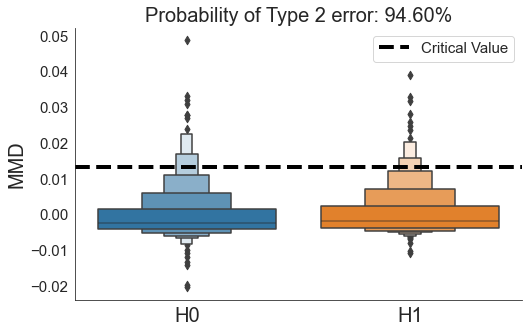

In [16]:
n_atoms   = 500
n_paths   = 128
alpha = 0.05

h0_dists, h1_dists = return_mmd_distributions(
    h0_paths, 
    h1_paths, 
    signature_kernel.compute_mmd, 
    n_atoms=n_atoms, 
    batch_size=n_paths, 
    estimator='ub'
)

df = pd.DataFrame({'H': ['H0' for _ in range(len(h0_dists))] + ['H1' for _ in range(len(h1_dists))], 'MMD': h0_dists + h1_dists})
crit_val = np.sort(np.asarray(h0_dists))[int(n_atoms*(1-alpha))]    
title = f"Probability of Type 2 error: {100*expected_type2_error(torch.tensor(h1_dists), crit_val):.2f}%"
plot_dist_boxen(df, 'H', 'MMD', crit_val=crit_val, title=title, y_label='MMD', filename='type_2_dist_mixutre_model_scenario1_no_scaling.svg', svg=True)

In [7]:
ks = [1, 2, 3, 4, 5, 6]
path_bank_size = num_sim
level_dict = {}
n_atoms = 100
for n_paths in [128, 512, 2000]:
    h0_Mk_vals, h1_Mk_vals = get_level_values(torch.multiply(torch.Tensor([1, 1]).to(device=device), h0_paths[:, :, :]), 
                                              torch.multiply(torch.Tensor([1, 1]).to(device=device), h1_paths[:, :, :]), n_atoms, n_paths, ks, num_sim)
    h0_Mk_vals = np.asarray(h0_Mk_vals)
    h1_Mk_vals = np.asarray(h1_Mk_vals)
    level_dict[f'H0_{n_paths}'] = h0_Mk_vals
    level_dict[f'H1_{n_paths}'] = h1_Mk_vals

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [04:22<00:00,  2.63s/it]


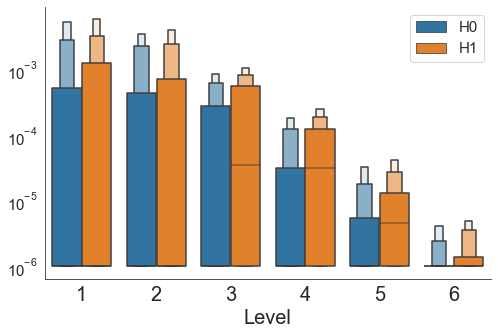

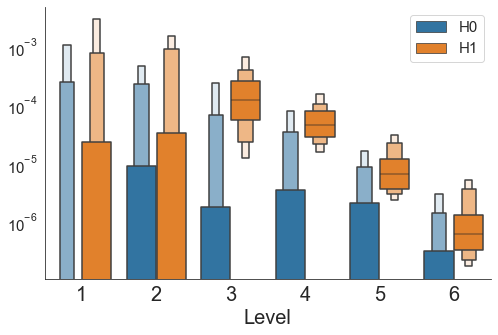

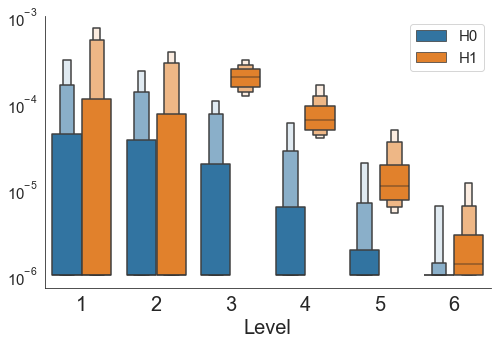

In [10]:
n_paths = 128
df = pd.DataFrame({'H': ['H0' for _ in range(n_atoms * len(ks))] + ['H1' for _ in range(n_atoms * len(ks))], 
                   'Level': np.tile(np.asarray([[i for _ in range(n_atoms)] for i in ks]).flatten(), 2), 
                   'MMD': np.fmax(1e-6, np.concatenate((level_dict[f'H0_{n_paths}'].flatten(), level_dict[f'H1_{n_paths}'].flatten())))})
filename = f'mixutre_model_scenario1_128_boxen.svg'
plot_dist_boxen(df, 'Level', 'MMD', hue='H', x_label='Level', log_scale=True, showfliers=False, filename=filename)



n_paths = 512
df = pd.DataFrame({'H': ['H0' for _ in range(n_atoms * len(ks))] + ['H1' for _ in range(n_atoms * len(ks))],
                   'Level': np.tile(np.asarray([[i for _ in range(n_atoms)] for i in ks]).flatten(), 2), 
                   'MMD': np.fmax(0, np.concatenate((level_dict[f'H0_{n_paths}'].flatten(), level_dict[f'H1_{n_paths}'].flatten())))})
filename = f'mixutre_model_scenario1_512_boxen.svg'
plot_dist_boxen(df, 'Level', 'MMD', hue='H', x_label='Level', log_scale=True, showfliers=False, filename=filename)

    

n_paths = 2000
df = pd.DataFrame({'H': ['H0' for _ in range(n_atoms * len(ks))] + ['H1' for _ in range(n_atoms * len(ks))], 
                   'Level': np.tile(np.asarray([[i for _ in range(n_atoms)] for i in ks]).flatten(), 2), 
                   'MMD': np.fmax(1e-6, np.concatenate((level_dict[f'H0_{n_paths}'].flatten(), level_dict[f'H1_{n_paths}'].flatten())))})
filename = f'mixutre_model_scenario1_2000_boxen.svg'
plot_dist_boxen(df, 'Level', 'MMD', hue='H', x_label='Level', log_scale=True, showfliers=False, filename=filename)

#### Apply scaling

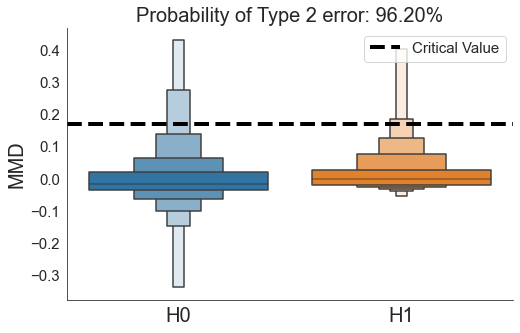

In [18]:
n_atoms   = 500
n_paths   = 128
alpha = 0.05

scaling = 2.0

h0_dists, h1_dists = return_mmd_distributions(
    torch.multiply(torch.Tensor([scaling, 1]).to(device=device), h0_paths[:, :, :]), 
    torch.multiply(torch.Tensor([scaling, 1]).to(device=device), h1_paths[:, :, :]), 
    signature_kernel.compute_mmd, 
    n_atoms=n_atoms, 
    batch_size=n_paths, 
    estimator='ub'
)

df = pd.DataFrame({'H': ['H0' for _ in range(len(h0_dists))] + ['H1' for _ in range(len(h1_dists))], 'MMD': h0_dists + h1_dists})
crit_val = np.sort(np.asarray(h0_dists))[int(n_atoms*(1-alpha))]    
title = f"Probability of Type 2 error: {100*expected_type2_error(torch.tensor(h1_dists), crit_val):.2f}%"
plot_dist_boxen(df, 'H', 'MMD', crit_val=crit_val, title=title, y_label='MMD', filename=f'type_2_dist_mixutre_model_scenario1_scaling_{scaling}.svg', svg=True, showfliers=False)

In [11]:
ks = [1, 2, 3, 4, 5, 6]
path_bank_size = num_sim
level_dict = {}
n_atoms = 100
scaling = 2.0
for n_paths in [128, 512, 2000]:
    h0_Mk_vals, h1_Mk_vals = get_level_values(torch.multiply(torch.Tensor([scaling, 1]).to(device=device), h0_paths[:, :, :]), 
                                              torch.multiply(torch.Tensor([scaling, 1]).to(device=device), h1_paths[:, :, :]), n_atoms, n_paths, ks, num_sim)
    h0_Mk_vals = np.asarray(h0_Mk_vals)
    h1_Mk_vals = np.asarray(h1_Mk_vals)
    level_dict[f'H0_{n_paths}'] = h0_Mk_vals
    level_dict[f'H1_{n_paths}'] = h1_Mk_vals

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [04:54<00:00,  2.94s/it]


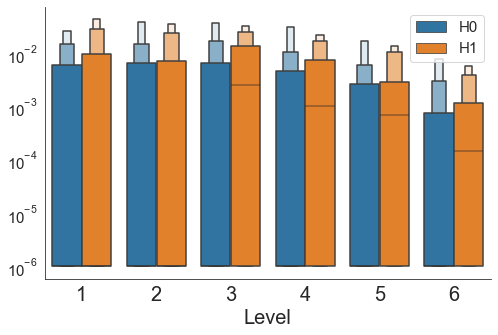

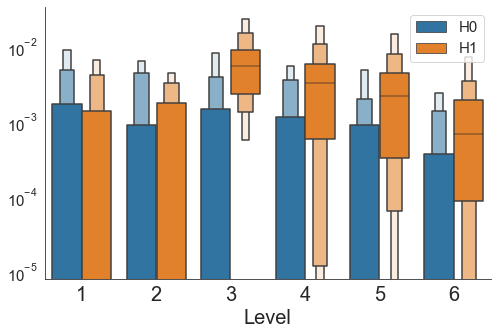

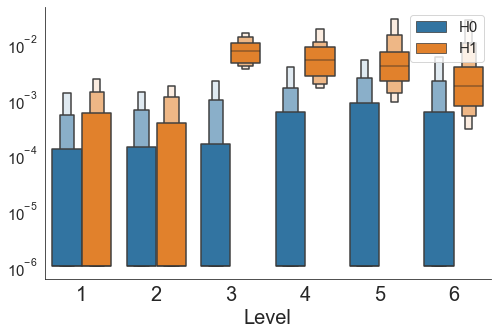

In [13]:
n_paths = 128
df = pd.DataFrame({'H': ['H0' for _ in range(n_atoms * len(ks))] + ['H1' for _ in range(n_atoms * len(ks))], 
                   'Level': np.tile(np.asarray([[i for _ in range(n_atoms)] for i in ks]).flatten(), 2), 
                   'MMD': np.fmax(1e-6, np.concatenate((level_dict[f'H0_{n_paths}'].flatten(), level_dict[f'H1_{n_paths}'].flatten())))})
filename = f'mixutre_model_scenario1_{n_paths}_{scaling}scaling_boxen.svg'
plot_dist_boxen(df, 'Level', 'MMD', hue='H', x_label='Level', log_scale=True, showfliers=False, filename=filename)



n_paths = 512
df = pd.DataFrame({'H': ['H0' for _ in range(n_atoms * len(ks))] + ['H1' for _ in range(n_atoms * len(ks))],
                   'Level': np.tile(np.asarray([[i for _ in range(n_atoms)] for i in ks]).flatten(), 2), 
                   'MMD': np.fmax(0, np.concatenate((level_dict[f'H0_{n_paths}'].flatten(), level_dict[f'H1_{n_paths}'].flatten())))})
filename = f'mixutre_model_scenario1_{n_paths}_{scaling}scaling_boxen.svg'
plot_dist_boxen(df, 'Level', 'MMD', hue='H', x_label='Level', log_scale=True, showfliers=False, filename=filename)

    

n_paths = 2000
df = pd.DataFrame({'H': ['H0' for _ in range(n_atoms * len(ks))] + ['H1' for _ in range(n_atoms * len(ks))], 
                   'Level': np.tile(np.asarray([[i for _ in range(n_atoms)] for i in ks]).flatten(), 2), 
                   'MMD': np.fmax(1e-6, np.concatenate((level_dict[f'H0_{n_paths}'].flatten(), level_dict[f'H1_{n_paths}'].flatten())))})
filename = f'mixutre_model_scenario1_{n_paths}_{scaling}scaling_boxen.svg'
plot_dist_boxen(df, 'Level', 'MMD', hue='H', x_label='Level', log_scale=True, showfliers=False, filename=filename)

### RBF and Lead-Lag <a class="anchor" id="rbf_ll"></a>

In [7]:
def lead_lag_transformation(path):
    print(path.shape)
    if type(path) == list:
        n = len(path)
    else:
        n = path.shape[1]
        
    dt = path[0, -1, 1]/(n-1) * 1/2
    
    lead_path = np.zeros((path.shape[0], path.shape[1]*2 + 1, path.shape[-1]))
    lag_path = np.zeros((path.shape[0], path.shape[1]*2 + 1, path.shape[-1]))
    
    for i in range(1, int(2*n)):
        
        if i % 2 == 0:            
            lead_path[:, i, :] = np.concatenate((path[:, int((i+2)/2 - 1), 0][:, None], (i-1)*dt*np.ones(path.shape[0])[:, None]), axis=1)
            lag_path[:, i, :] = np.concatenate((path[:, int(i/2 - 1), 0][:, None], (i-1)*dt*np.ones(path.shape[0])[:, None]), axis=1)
            
        else:
            lead_path[:, i, :] = np.concatenate((path[:, int((i+1)/2 - 1), 0][:, None], (i-1)*dt*np.ones(path.shape[0])[:, None]), axis=1)
            lag_path[:, i, :] = np.concatenate((path[:, int((i+1)/2 - 1), 0][:, None], (i-1)*dt*np.ones(path.shape[0])[:, None]), axis=1)

    lead_path[:, 0, :] = lead_path[:, 1, :]
    return lead_path[:, 1:-1, :], lag_path[:, 1:-1, :], np.concatenate((lead_path[:, 1:-1, :1], lag_path[:, 1:-1, :]), axis=2)

In [8]:
mean_h0 = torch.mean(h0_paths[:, -1, :1].squeeze(1))
std_h0 = torch.std(h0_paths[:, -1, :1].squeeze(1))

mean_h1 = torch.mean(h1_paths[:, -1, :1].squeeze(1))
std_h1 = torch.std(h1_paths[:, -1, :1].squeeze(1))

for i in range(num_sim):
    h0_paths[i, :, :1] = (h0_paths[i, :, :1] - mean_h0)/std_h0
    h1_paths[i, :, :1] = (h1_paths[i, :, :1] - mean_h1)/std_h1

h0_paths = torch.Tensor(lead_lag_transformation(np.asarray(h0_paths[:, :, :].cpu()))[-1]).to(device=device)
h1_paths = torch.Tensor(lead_lag_transformation(np.asarray(h1_paths[:, :, :].cpu()))[-1]).to(device=device)

(10000, 30, 2)
(10000, 30, 2)


In [9]:
dyadic_order  = 0
sigma = 0.5
scaling = 1.0
static_kernel = RBFKernel(sigma=sigma, scaling=scaling)
rbf_signature_kernel = SigKernel(static_kernel=static_kernel, dyadic_order=dyadic_order)

100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [05:48<00:00,  1.43it/s]


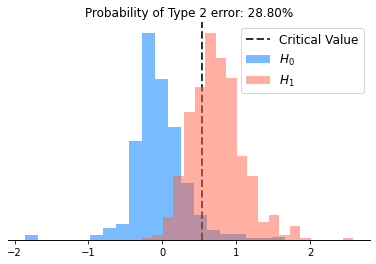

In [10]:
n_atoms   = 500
n_paths   = 128
alpha = 0.05

h0_dists, h1_dists = return_mmd_distributions(
    h0_paths, 
    h1_paths, 
    rbf_signature_kernel.compute_mmd, 
    n_atoms=n_atoms, 
    batch_size=n_paths, 
    estimator='ub'
)

plot_dist(h0_dists, h1_dists, n_atoms, alpha, f'mixture_model_scenario1_rbf_leadlag_sigma{sigma}_scaling{scaling}.svg', svg=True, filter_zero=False)

In [14]:
dyadic_order  = 0
sigma = 0.5
scaling = 0.8
static_kernel = RBFKernel(sigma=sigma, scaling=scaling)
rbf_signature_kernel = SigKernel(static_kernel=static_kernel, dyadic_order=dyadic_order)

100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [05:47<00:00,  1.44it/s]


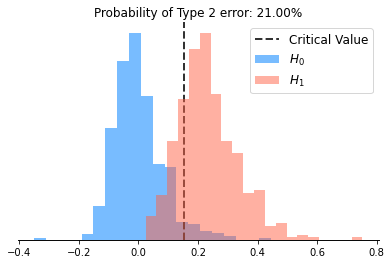

In [15]:
n_atoms   = 500
n_paths   = 128
alpha = 0.05

h0_dists, h1_dists = return_mmd_distributions(
    h0_paths, 
    h1_paths, 
    rbf_signature_kernel.compute_mmd, 
    n_atoms=n_atoms, 
    batch_size=n_paths, 
    estimator='ub'
)

plot_dist(h0_dists, h1_dists, n_atoms, alpha, f'mixture_model_scenario1_rbf_leadlag_sigma{sigma}_scaling{scaling}.svg', svg=True, filter_zero=False)

### Relationship between Scaling, Batch Size, and Errors <a class="anchor" id="batchsize-scaling"></a>

In [3]:
scalings = np.linspace(1e-5, 1.2, 20)
n_paths_list = [20, 40, 60, 120]
n_atoms   = 100
alpha = 0.05

#### Sigma = 0.1

In [ ]:
sigma = 0.1
num_sim = 100
type1_list_unbiased_01, type2_list_unbiased_01 = generate_error_probs_rbf_kernel(h0_paths, 
                                                                                 h1_paths,
                                                                                 sigma,
                                                                                 n_atoms,
                                                                                 n_paths_list, 
                                                                                 alpha,
                                                                                 scalings,
                                                                                 'ub', 
                                                                                 num_sim, 
                                                                                 device, 
                                                                                 filename='mixture_unbiased_01', 
                                                                                 folder='MixtureData/')

type1_list_biased_01, type2_list_biased_01 = generate_error_probs_rbf_kernel(h0_paths, 
                                                                             h1_paths,
                                                                             sigma,
                                                                             n_atoms,
                                                                             n_paths_list, 
                                                                             alpha, 
                                                                             scalings,
                                                                             'b', 
                                                                             num_sim, 
                                                                             device, 
                                                                             filename='mixture_biased_01', 
                                                                             folder='MixtureData/')

In [4]:
with open("MixtureData/type1error_mixture_unbiased_01", "rb") as fp: 
    type1_list_unbiased_01 = pickle.load(fp)

with open("MixtureData/type2error_mixture_unbiased_01", "rb") as fp: 
    type2_list_unbiased_01 = pickle.load(fp)
    
with open("MixtureData/type1error_mixture_biased_01", "rb") as fp: 
    type1_list_biased_01 = pickle.load(fp)

with open("MixtureData/type2error_mixture_biased_01", "rb") as fp: 
    type2_list_biased_01 = pickle.load(fp)

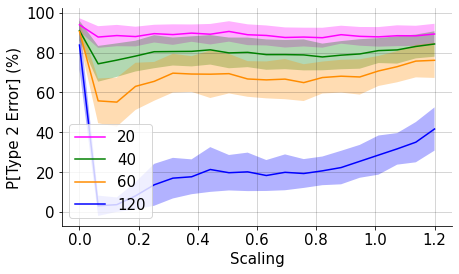

In [6]:
plot_type2_error(type2_list_unbiased_01, scalings, n_paths_list, title='Unbiased')

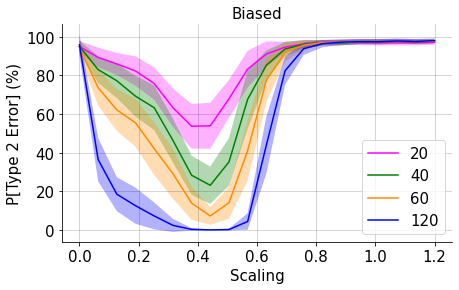

In [9]:
plot_type2_error(type2_list_biased_01, scalings, n_paths_list, title='Biased')

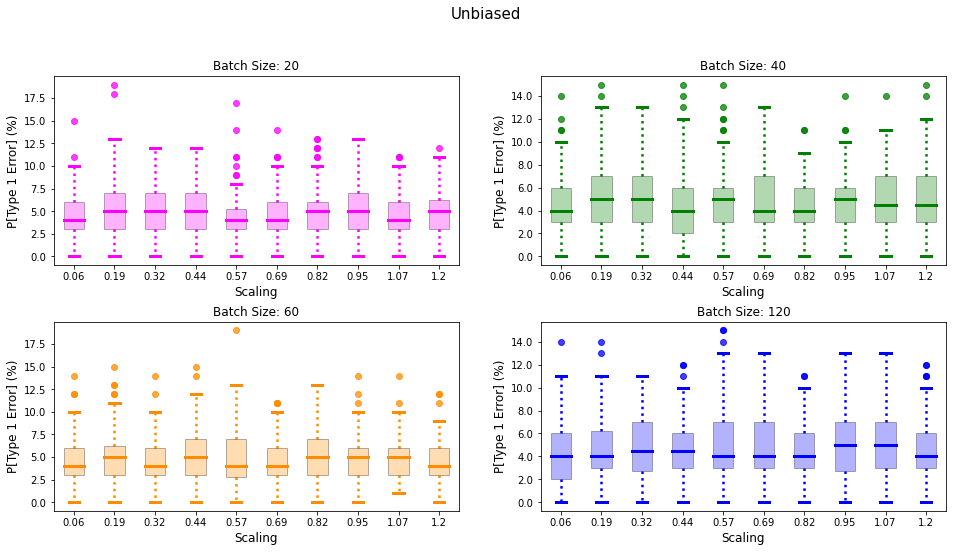

In [108]:
plot_type1_error(type1_list_unbiased_01, scalings, n_paths_list, title='Unbiased')

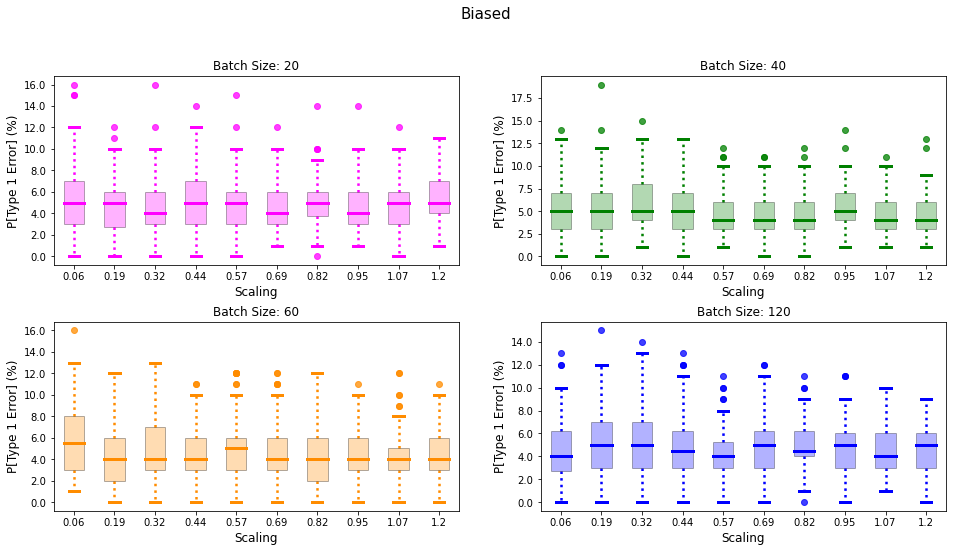

In [109]:
plot_type1_error(type1_list_biased_01, scalings, n_paths_list, title='Biased')

#### Sigma = 0.5

In [ ]:
sigma = 0.5
num_sim = 100
type1_list_unbiased_05, type2_list_unbiased_05 = generate_error_probs_rbf_kernel(h0_paths, 
                                                                                 h1_paths,
                                                                                 sigma,
                                                                                 n_atoms,
                                                                                 n_paths_list, 
                                                                                 alpha, 
                                                                                 scalings,
                                                                                 'ub', 
                                                                                 num_sim, 
                                                                                 device, 
                                                                                 filename='mixture_unbiased_05', 
                                                                                 folder='MixtureData/')

type1_list_biased_05, type2_list_biased_05 = generate_error_probs_rbf_kernel(h0_paths, 
                                                                             h1_paths,
                                                                             sigma,
                                                                             n_atoms,
                                                                             n_paths_list, 
                                                                             alpha, 
                                                                             scalings,
                                                                             'b', 
                                                                             num_sim, 
                                                                             device, 
                                                                             filename='mixture_biased_05', 
                                                                             folder='MixtureData/')

In [10]:
with open("MixtureData/type1error_mixture_unbiased_05", "rb") as fp: 
    type1_list_unbiased_05 = pickle.load(fp)

with open("MixtureData/type2error_mixture_unbiased_05", "rb") as fp: 
    type2_list_unbiased_05 = pickle.load(fp)
    
with open("MixtureData/type1error_mixture_biased_05", "rb") as fp: 
    type1_list_biased_05 = pickle.load(fp)

with open("MixtureData/type2error_mixture_biased_05", "rb") as fp: 
    type2_list_biased_05 = pickle.load(fp)

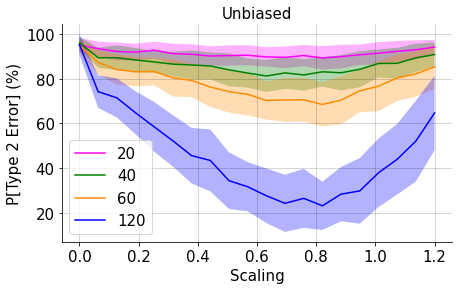

In [12]:
plot_type2_error(type2_list_unbiased_05, scalings, n_paths_list, title='Unbiased')

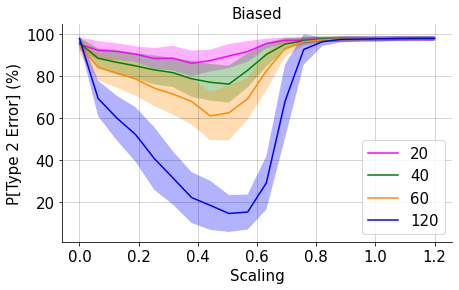

In [14]:
plot_type2_error(type2_list_biased_05, scalings, n_paths_list, title='Biased')

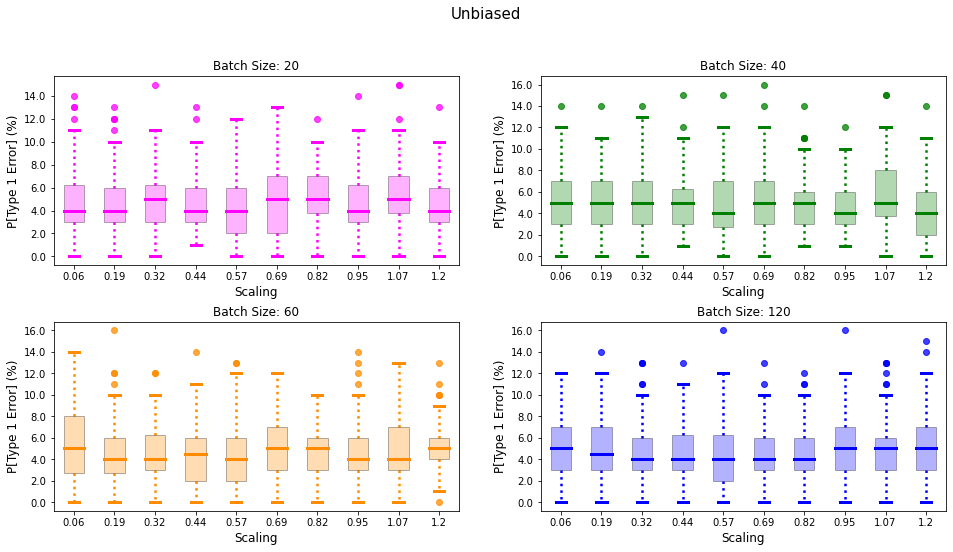

In [111]:
plot_type1_error(type1_list_unbiased_05, scalings, n_paths_list, title='Unbiased')

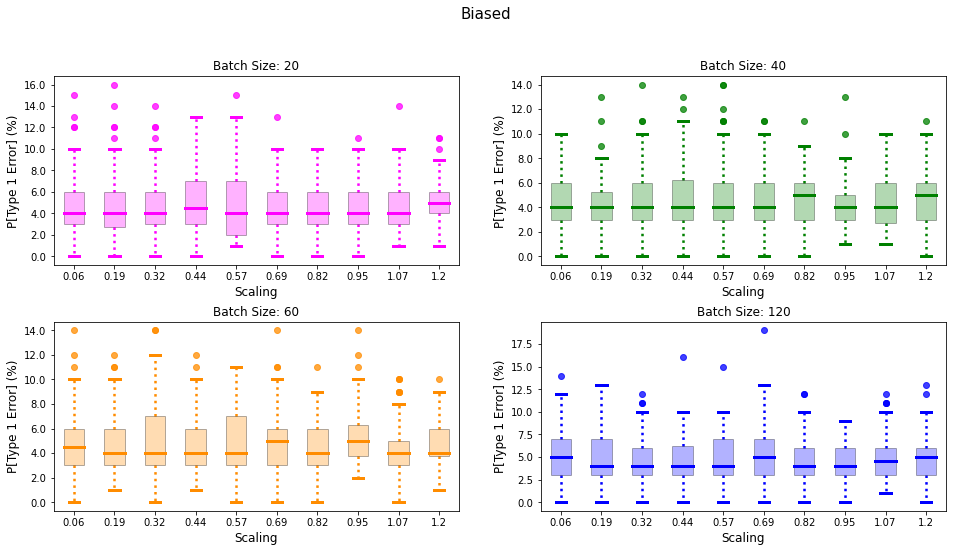

In [110]:
plot_type1_error(type1_list_biased_05, scalings, n_paths_list, title='Biased')